In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import warnings
from matplotlib.patches import Patch

# 1. 全局字体设置
try:
    rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei']
    rcParams['axes.unicode_minus'] = False
except Exception as e:
    warnings.warn(f"字体设置失败: {str(e)}")

def plot_error_map(data_file_path, shapefile_path, output_figure_path=None):
    """
    根据数据文件路径绘制单张产量预测误差图
    
    参数:
    data_file_path -- str: 数据文件路径(Excel格式)
    shapefile_path -- str: 地理信息文件路径
    output_figure_path -- str: 可选,保存图片的路径,如果不提供则显示但不保存
    """
    # 准备地理数据
    gdf = gpd.read_file(shapefile_path)
    gdf[['province_code', 'city_code']] = gdf[['省级码', '区划码']].astype(int)
    
    # 尝试加载数据
    try:
        # 读取整个Excel文件
        df = pd.read_excel(data_file_path)
        df[['province_code', 'city_code']] = df[['province_code', 'city_code']].astype(int)
    except Exception as e:
        raise ValueError(f"数据加载失败: {str(e)}")
    
    # 合并地理数据和预测数据
    merged = gdf.merge(df, on=['province_code', 'city_code'], how='left')
    
    # 计算相对误差
    merged['error'] = (merged['预测值'] - merged['真实值']) / merged['真实值']
    vmin, vmax = merged['error'].min(), merged['error'].max()
    mre = (merged['error'].abs().mean()) * 100  # 计算平均绝对相对误差
    
    # 计算全局地理范围
    min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
    
    # 创建画布
    fig, ax = plt.subplots(figsize=(12, 10), dpi=300, facecolor='white')
    
    # 设置地理刻度参数
    lon_step = 3  # 经度间隔
    lat_step = 2  # 纬度间隔
    
    # 生成经纬度刻度
    lon_ticks = np.arange(np.floor(min_lon), np.ceil(max_lon)+1, lon_step)
    lat_ticks = np.arange(np.floor(min_lat), np.ceil(max_lat)+1, lat_step)
    
    # 绘制有数据区域
    valid = merged[merged['error'].notna()]
    if not valid.empty:
        valid.plot(column='error', ax=ax, cmap='coolwarm', 
                  vmin=vmin, vmax=vmax, edgecolor='k', linewidth=0.5)
    
    # 绘制无数据区域
    invalid = merged[merged['error'].isna()]
    if not invalid.empty:
        invalid.plot(ax=ax, facecolor='none', edgecolor='gray', 
                    linewidth=0.8, hatch='///', alpha=0.3)
    
    # 设置地理范围和坐标轴
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    
    # 设置经纬度刻度
    ax.set_xticks(lon_ticks)
    ax.set_yticks(lat_ticks)
    ax.set_xticklabels([f'{x:.0f}°E' for x in lon_ticks], fontsize=12)
    ax.set_yticklabels([f'{y:.0f}°N' for y in lat_ticks], fontsize=12)
    
    # 美化坐标轴
    ax.tick_params(axis='both', which='both', length=5)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('black')
    
    ax.set_title(f'产量预测误差 (MRE: {mre:.2f}%)', fontsize=16, pad=10)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # 添加颜色条
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array(merged['error'])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.8, pad=0.05, format='%.2f')
    cbar.set_label('相对误差(RE)', fontsize=12, labelpad=10)
    cbar.ax.tick_params(labelsize=10)
    
    # 添加缺失数据图例
    no_data_patch = Patch(facecolor='none', edgecolor='gray', 
                         linewidth=0.8, hatch='////', alpha=0.3, label='缺失数据')
    ax.legend(handles=[no_data_patch], loc='upper left', fontsize=10)
    
    # 保存或显示图形
    if output_figure_path:
        plt.savefig(output_figure_path, bbox_inches='tight', dpi=300)
        plt.close()
        print(f"图形已保存至: {output_figure_path}")
    else:
        plt.tight_layout()
        plt.show()

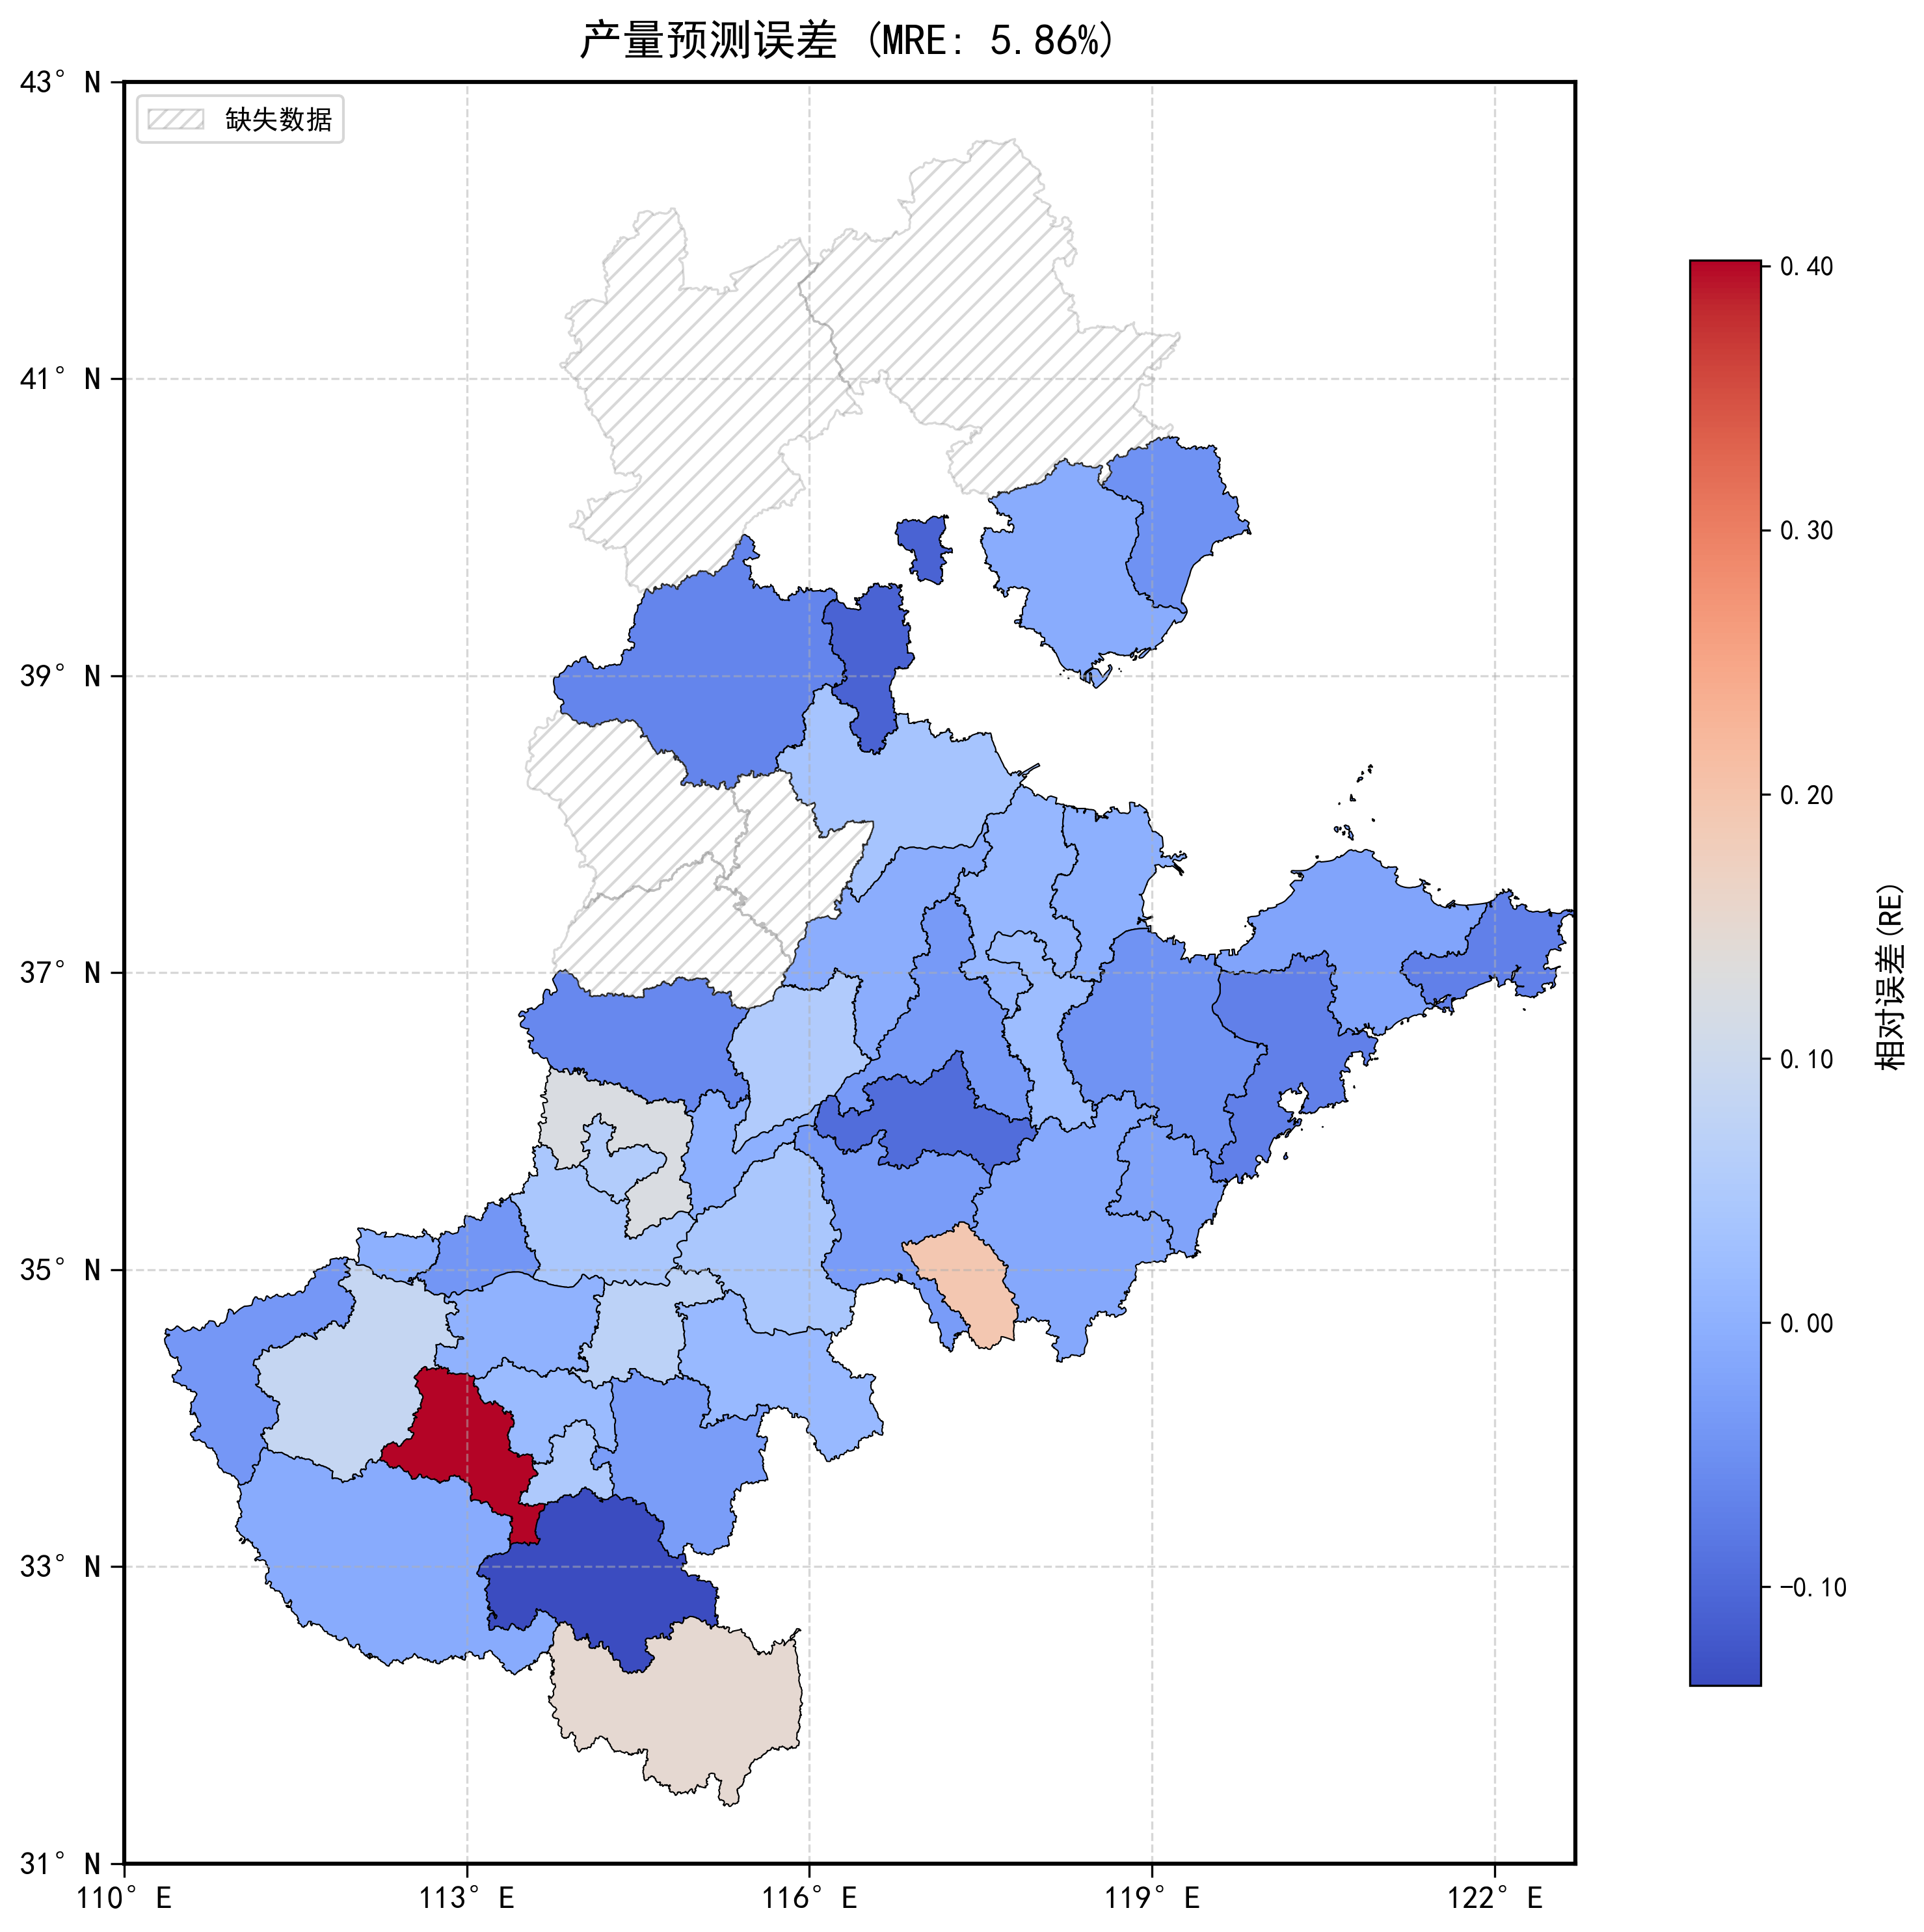

In [2]:
plot_error_map(
    data_file_path=r"D:\python\crop_yield_prediction\2016年产量预测评估_3DCNN_xLSTM_without.xlsx",
    shapefile_path="D:/Crop/NCC/NCC.shp",
    # output_figure_path="可选_输出图片路径.png"  # 如果不提供则直接显示图形
)
